In [11]:
%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
rcParams['figure.dpi'] = 150
rcParams["figure.facecolor"] = 'white'
rc('text.latex',preamble=r'\usepackage{/Users/sraghunathan/.configs/apjfonts}')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import sys, numpy as np, glob
sys.path.append('/Users/sraghunathan/Research/SPTPol/analysis/git/ilc/DRAFT/')
import flatsky, tools, misc

In [13]:
camb_file = 'output_planck_r_0.0_2015_cosmo_lensedCls.dat'
Tcmb = 2.73
el_camb = np.loadtxt(camb_file, usecols = [0])
dl_camb = np.loadtxt(camb_file, usecols = [1,2,3,4])

cl_camb = ( Tcmb**2. * dl_camb * 2 * np.pi ) / ( el_camb[:,None] * (el_camb[:,None] + 1) )
cl_camb *= 1e12
cl_TT, cl_EE, cl_BB, cl_TE = cl_camb.T


In [20]:
#get all the files
flist = glob.glob('*.npy')
#flist = sorted(flist, reverse = 1)
flist = [flist[0], flist[3], flist[1], flist[2], flist[4]]
print(flist)

['S4_ilc_20204020_galaxy0.npy', 'S4_ilc_20204020_galaxy1_galmask1.npy', 'S4_ilc_20204020_galaxy1_galmask2.npy', 'S4_ilc_20204020_galaxy1_galmask3.npy', 'S4_ilc_20204020_galaxy1_galmask0.npy']


In [21]:
#get beam deconvolved noise nls
beam_noise_dic = np.load(flist[0], allow_pickle=1).item()['beam_noise_dic']
#print(beam_noise_dic)
elknee_dic = np.load(flist[0], allow_pickle=1).item()['elknee_dic']
param_dict = np.load(flist[0], allow_pickle=1).item()['param_dict']

corr_noise_bands = {20: [20], 27:[39], 39:[27], 93:[145], 145:[93], 225: [278], 278: [225]}
rho = 0.9
freqarr = [93, 145]
TParr = ['T']#, 'P']
el = np.arange(param_dict['lmax'])

nl_dic = {}
for TP in TParr:
    nl_dic[TP]={}
    for freq1 in freqarr:
        beamval1, noiseval1 = beam_noise_dic[TP][freq1]
        #print(beamval1, noiseval1)
        elknee1, alphaknee1 = elknee_dic[TP][freq1]
        for freq2 in freqarr:        
            beamval2, noiseval2 = beam_noise_dic[TP][freq2]
            elknee2, alphaknee2 = elknee_dic[TP][freq2]
            
            if freq1 == freq2:
                nl = misc.get_nl(noiseval1, el, beamval1, elknee = elknee1, alphaknee = alphaknee1)
            else:
                if freq2 in corr_noise_bands[freq1]:
                    nl = misc.get_nl(noiseval1, el, beamval1, elknee = elknee1, alphaknee = alphaknee1, \
                                     beamval2 = beamval2, noiseval2 = noiseval2, elknee2 = elknee2, alphaknee2 = alphaknee2, rho = rho)
                else:
                    nl = np.zeros( len(el) )
            
            #print(freq1, freq2, nl)
            nl[el<=param_dict['lmin']] = 0.
            ##nl[nl == 0.] = np.min(nl[nl!=0.])/1e3
            nl_dic[TP][(freq1, freq2)] = nl
print(nl_dic['T'].keys())

dict_keys([(93, 93), (93, 145), (145, 93), (145, 145)])


S4_ilc_20204020_galaxy0.npy
S4_ilc_20204020_galaxy1_galmask1.npy
S4_ilc_20204020_galaxy1_galmask2.npy
S4_ilc_20204020_galaxy1_galmask3.npy
S4_ilc_20204020_galaxy1_galmask0.npy


Text(0.5, 1.0, 'ILC residuals: S4-wide')

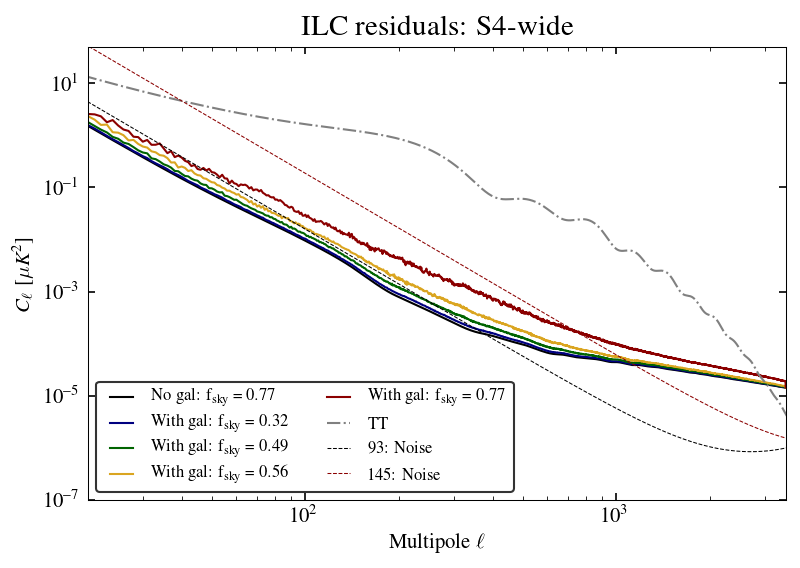

In [34]:
clf()
ax = subplot(111, xscale = 'log', yscale = 'log')
colorarr =['k', 'navy', 'darkgreen', 'goldenrod', 'darkred']
for fcntr, fname in enumerate( flist ):
    print(fname)
    resdic = np.load(fname, allow_pickle=1).item()
    if fname.find('galaxy0')>-1:
        lab = 'No gal'
    else:
        lab = 'With gal'
    fsky = resdic['fsky_val']
    lab = r'%s: f$_{\rm sky}=%.2f$' %(lab, fsky)
    el = resdic['el']
    cl_res = resdic['cl_residual']['T']
    plot(el, cl_res, label = lab, color = colorarr[fcntr])
    
plot(el_camb, cl_TT, 'gray', ls = '-.', lw = 1., label = r'TT')
for nucntr, nu1nu2 in enumerate( nl_dic['T'] ):
    nu1, nu2 = nu1nu2
    if nu1 != nu2: continue
    plot(nl_dic['T'][nu1nu2], ls = '--', lw = 0.5, label = r'%s: Noise' %(nu1))
legend(loc = 3, fancybox = 1, ncol = 2, fontsize = 8)
xlim(20,3500);ylim(1e-7,50);
xlabel(r'Multipole $\ell$')
ylabel(r'$C_{\ell}\ [\mu K^{2}]$')
title(r'ILC residuals: S4-wide', fontsize = 14)